# Modelling Notebook- Numbers

In [1]:
require("epimdr")

Loading required package: epimdr
Loading required package: shiny
Loading required package: deSolve
Loading required package: polspline


## Basic SEIR Model

$\frac{dS}{dt}=\nu N-\frac{\beta S}{N}\times I-\mu S\\
\frac{dE}{dt}=\frac{\beta IS}{N}-(\sigma+\mu)E\\
\frac{dI}{dt}=\sigma E-(\alpha+\mu+\gamma)I\\
\frac{dR}{dt}=\gamma I-\mu R$

Modified from Bjornstad (2018) and Keeling and Rohani (2007).
the models are slightly different, particularly in the meaning of S, E, I and R.  
Here, they are numbers and the population size is N. Other parameters should be equivalent between models.  
$\mu$ is the natural death rate per capita (assumed to be equal to the birth rate) per day ($day^-1$).  
$\nu$ is the natural birth rate per capita per day ($day^-1$).  
$\beta$ is the transmission rate per infective per day (i.e the number of individuals that an infective could transmit the disease to in one day-if all contacts are with susceptible)($day^-1$).  The number of susceptible individuals that become exposed is I x the probability that a contact is with a susceptible individual (S/N) x the transmission rate per infective .  
$\gamma$ is the recovery rate (reciprocal of infectious period)($day^-1$) .  
$\sigma$ is the rate of movement from E to I (reciprical of latent period). per capita movement from I to R per day ($day^-1$).  
$\alpha$ is rate of disease induced mortality (per capita disease induced death rate per day).  


how does day work with dx/dt

There is an option to make this more complex (i.e include hospitalisation and asymptomatic) which would make it more accurate (particularly in the distribution of the infectious period) but I don't think would improve understanding of the processes relevant to this project. 


In [2]:
model <- function(time, values, parms) {
  S <- values[1]
  E <- values[2]
  I <- values[3]
  R <- values[4]
 
  beta <- parms[["beta"]]
  mu <- parms[["mu"]]
  sigma <- parms[["sigma"]]
  alpha <- parms[["alpha"]]
  gamma <- parms[["gamma"]]
  N <- parms[["N"]]
  nu <- parms[["nu"]]
    
  dS = nu * N - (beta * I * S) / N - mu * S
  dE = (beta * S * I) / N - (sigma + mu) * E
  dI = sigma * E - (alpha + mu + gamma) * I
  dR = gamma * I - mu * R
  list(c(dS, dE, dI, dR))
}

In [3]:
plottime <- function(start, time, model, parms) {
  out = ode(
    y = start,
    time = time,
    func = model,
    parms = parms
  )
  Nvec<-out[, "S"] + out[, "E"] + out[, "I"] + out[, "R"]
  out<-cbind( out, Nvec)
  plot(x = out[, "time"],    y = out[, "S"],    ylab = "Number",   xlab = "Time",    type = "l",   xlim=c(min(time), max(time)),  ylim=c(0, parms[["N"]])
  )
  lines(x = out[, "time"], y = out[, "E"], col = "orange")
  lines(x = out[, "time"], y = out[, "I"], col = "red")
  lines(x = out[, "time"], y = out[, "R"], col = "green")
  lines(x = out[, "time"], y = out[, "Nvec"], col = "purple")  
  legend( "bottomleft",legend = c("S", "E", "I", "R","N"), col = c("black", "orange", "red", "green","purple"),lty = 1,    cex = 0.8
  )
}

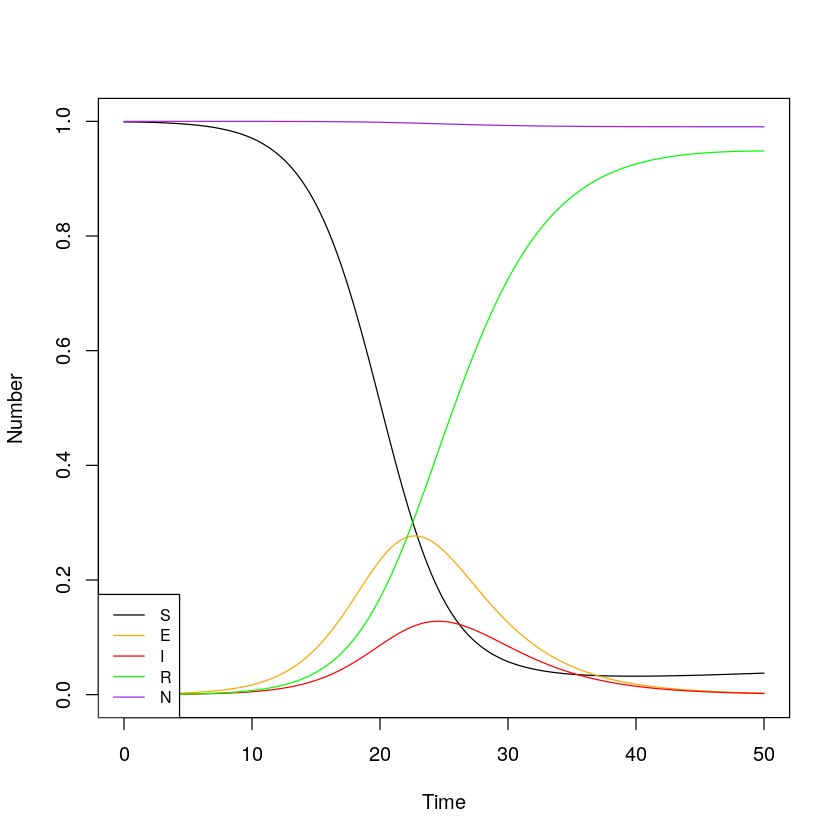

In [4]:
time = seq(0, 50, by = 1 / 10)
#parameters from bjornstad book and guesses- just to test functions work!
parms = list(
  mu = 0.001,
  sigma = 0.25 ,
  alpha = 0.005,
  beta = 2,
  gamma = 1 / 2,
  N=1,
  nu=0.001
)
start = c(S = 0.999,
          E = 0.001,
          I = 0.00,
          R = 0)

plottime(start,time,model,parms)

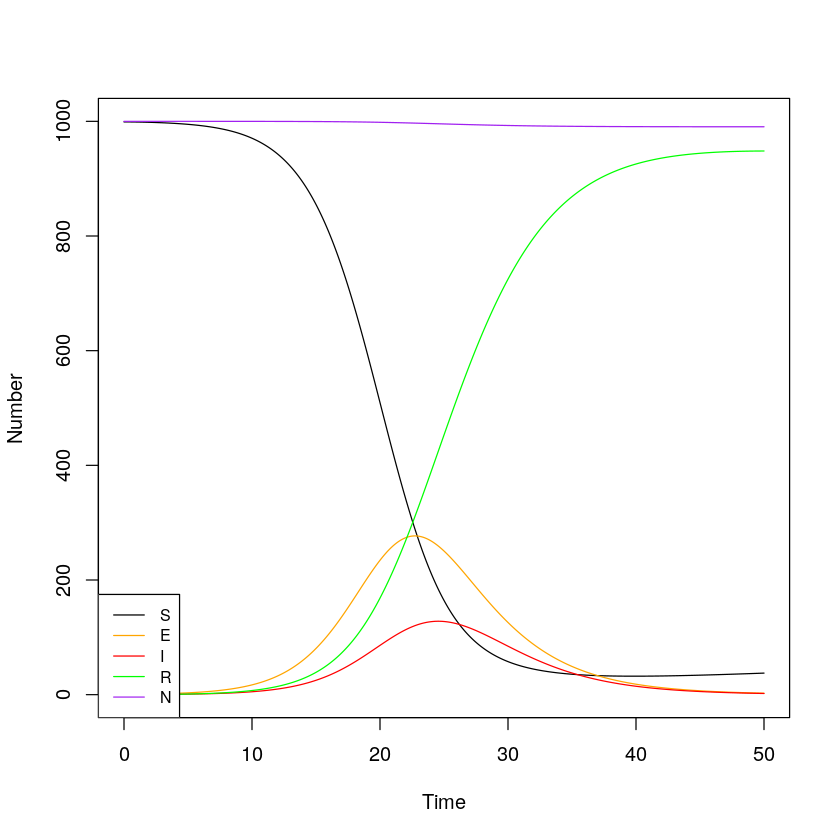

In [5]:
time = seq(0, 50, by = 1 / 10)
#parameters from bjornstad book and guesses- just to test functions work!
parms = list(
  mu = 0.001,
  sigma = 0.25 ,
  alpha = 0.005,
  beta = 2,
  gamma = 1 / 2,
  N=1000,
  nu=0.001
)
start = c(S = 999,
          E = 1,
          I = 0,
          R = 0)

plottime(start,time,model,parms)

## Addition of Infection Control Measures


I am interested in understanding how these interact with climate variables.

more reading needed in this

### Social Distancing


Neher et al 2020 varied an dI/dt in a SIR model beta*S*I with a Hill function:

$\frac{dI}{dt}=(1-H)\beta SI-(\mu + \gamma)E \\
H=c\frac{I^3}{k^3+I^3}$


where c is a containment parameter c, H is a hill function of ofter 3 and K is the inflection point

I could add a similar modifier to the dE/dt part of my model. However could be easier to reduce contact rates by a percentage. i.e:

$ dE=\frac{\beta SI}{N}-(\sigma+\mu)E\\
\beta=contact*\beta_0$

where contact is the percentage of the original contact rate.
This makes mechanistic sense because when kappa is the average number of contacts an individual has per unit time (day is being used in my model) and c is the probability of successful transmission following a contact of an infected with a susceptible individual (chapter 2 keeling and rohani) :

$\beta_0=-\kappa\times \log(1-c)$

if the number of contacts per unit time was halved (for example):

$\beta=-(0.5\times\kappa_0)\times\log(1-c)\\
\beta=0.5\times(-\kappa_0\times \log(1-c))\\
\beta=0.5\times \beta_0$

In [6]:
time = seq(0, 50, by = 1 / 10)
#parameters from bjornstad book and guesses- just to test functions work!
parmscontact = list(
  mu = 0,
  sigma = 0.25 ,
  alpha = 0.005,
  beta0 = 2,
  gamma = 1 / 2,
  contact = 0.7,
  nu = 0,
  N = 1
)
start = c(S = 0.999,
          E = 0.001,
          I = 0.00,
          R = 0)
modelcontact <- function(time, values, parms) {
  S <- values[1]
  E <- values[2]
  I <- values[3]
  R <- values[4]
  beta0 <- parms[["beta0"]]
  mu <- parms[["mu"]]
  sigma <- parms[["sigma"]]
  alpha <- parms[["alpha"]]
  gamma <- parms[["gamma"]]
  contact <- parms[["contact"]]
  nu <- parms[["nu"]]
  N <- parms[["N"]]

    
  beta <- beta0 * contact
  dS = nu * N - beta * I * S / N - mu * S
  dE = beta * S * I / N - (sigma + mu) * E
  dI = sigma * E - (alpha + mu + gamma) * I
  dR = gamma * I - mu * R
  list(c(dS, dE, dI, dR))
}

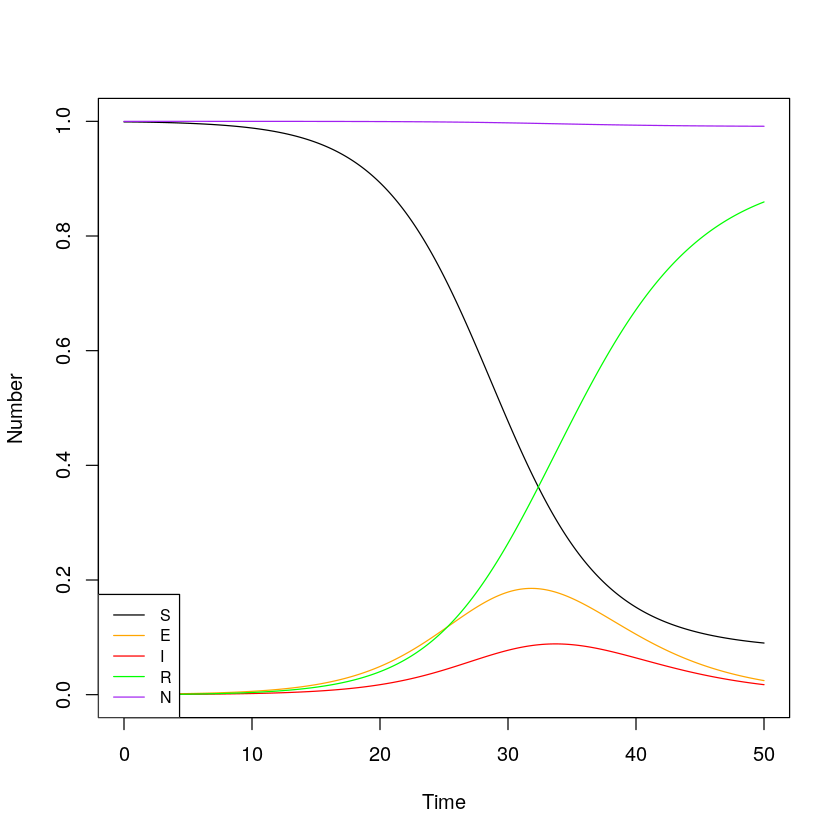

In [7]:
plottime(time=time,parms=parmscontact,start=start,model=modelcontact)

### Isolation of Infected


Could introduce a quarantine class to my SEIR model (Chapter 8, Keeling and Rohani 2007; p40 brauer)

parameters needed-average time in isolation , rate of detection of infectious individuals

## Age structure and Transmission

Would need to have compartments for each age group, and quantify how much contact exists between groups (using polymod study). So dE for each is the sum of S * B *(sum of I from each group multiplied by how much contact there is) 

I think this could be really interesting but is unlikely to be very helpful for answering my question! So leave **for now**.

## Climate

###  Beta


#### Modifying Beta (less mechanistic)

$\beta=\beta_{max}*contact*survivability$

<!---current idea- beta=survivability x maxbeta
mathematically similar to brauer p326 with effect of vaccination.

beta x thetas, where thetas is the factor to which vaccinated members have susceptiblity to infection reduced
so here, survivability could be the factor to which suboptimal climates reduce susceptibilityto infection)--->

<!--- #### Maxbeta
Maxbeta will be the maximum transmission rate (i.e if climate optimum for the virus). survivability is the percentage of the maximum transmission.
Not sure how to find Maxbeta. maxbeta could be calculate beta for loads of different regions at different points pre-lockdown and pick the highest reasonable estimate.
May need to think more about virology here.--->

<!--- #### Survivability %
Survivability(temperature,humidity)= ???
Coronavirus studies have looked at virus titre over time for different times and humidity combinations. Somehow convert these into a smooth 3d function (temperature, humidity, survival), maybe at an arbitrary point in time (1 hour?). or maybe as a percent of maximum in the study. Other work has used a look up table with vapor pressure and transmission rate (Brenner 2017) and a function finding beta from lower and higher values of vapor pressure and corresponding transmission rates. The data used for this was experiments on transmission of influenza between guinea pigs. However actually transmission rate data does not seem to be available for coronaviruses. I could use this approach for the survivability aspect though instead of smoothing the function need to research available data (as more recent may be available) --->


<!--- Survivability(temperature,humidity)= ???--->

Coronavirus studies have looked at virus titre over time for different times and humidity combinations. Somehow convert these into a smooth 3d function (temperature, humidity, survival), maybe at an arbitrary point in time (1 hour?).
or maybe as a percent of maximum in the study. 
Other work has used a look up table with vapor pressure and transmission rate (Brenner 2017) and a function finding beta from lower and higher values of vapor pressure and corresponding transmission rates. The data used for this was experiments on transmission of influenza between guinea pigs. However actually transmission rate data does not seem to be available for coronaviruses. I could use this approach for the survivability aspect though instead of smoothing the function
need to research available data (as more recent may be available)

#### Beta expression

breaking down beta - need to estimate usual kappa and c

$\beta=-\kappa \times \log(1-c)$

c- the probably of infection following a contact- is what would be modified by climate (in lower temperatures, would be higher)
if c is reduced by 25% (not sure can use this without knowing c and kappa)
In this model, I am combining indirect and indirect transmission

$\beta=-\kappa \times \log(1-0.75\times c)$


for this to work need:  
usual values of c and kappa  (am yet to find studies that have done these and found values for this, which is concerning!)
would probably need to split up the function into contact transmission and indirect transmission  
function for how c varies with temperature and humidity (+precipitation?)

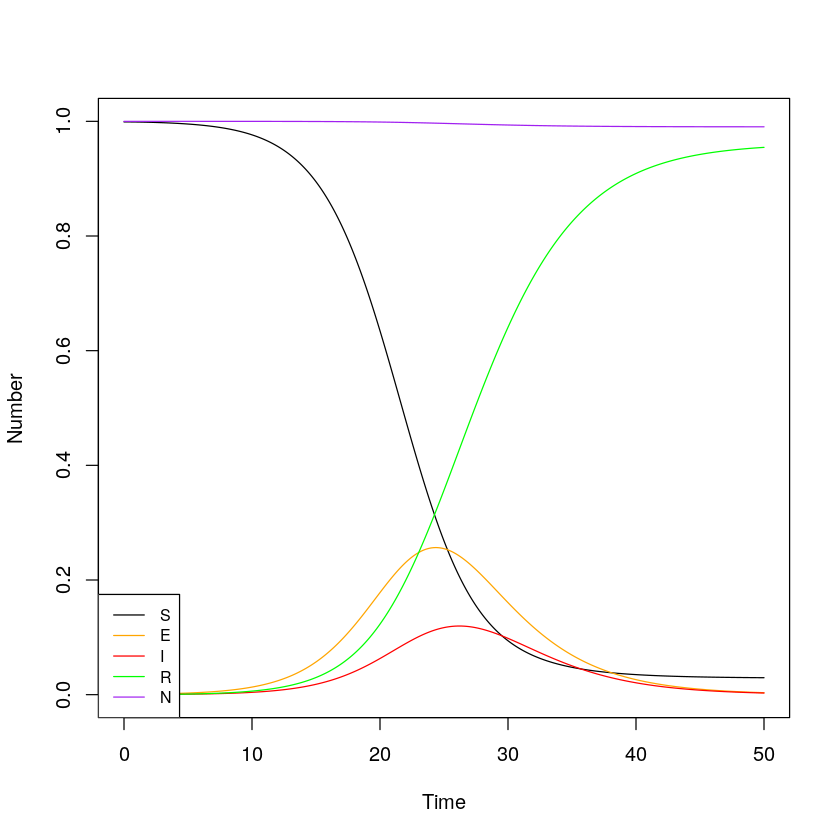

In [8]:


c_climate <- function(temp, humidity) {
  # this function will show how c varies with temp and humidity
  return(0.1)
}
modelclimate <- function(time, values, parms) {
  #this model is an SEIR model for a constant climate
  S <- values[1]
  E <- values[2]
  I <- values[3]
  R <- values[4]
  kappa0 <- parms[["kappa0"]]
  mu <- parms[["mu"]]
  sigma <- parms[["sigma"]]
  alpha <- parms[["alpha"]]
  gamma <- parms[["gamma"]]
  contact <- parms[["contact"]]
  temp <- parms[["temp"]]
  humidity <- parms[["humidity"]]
  c <- c_climate(temp, humidity)
  nu <- parms[["nu"]]
  N <- parms[["N"]]

  beta <- -contact * kappa0 * log(1 - c)
  dS = nu * N - beta * I * S / N - mu * S
  dE = beta * S * I / N - (sigma + mu) * E
  dI = sigma * E - (alpha + mu + gamma) * I
  dR = gamma * I - mu * R
    
  list(c(dS, dE, dI, dR))
}
time = seq(0, 50, by = 1 / 10)
#parameters from bjornstad book and guesses- just to test functions work!
parmsclimate = list(
  mu = 0,
  sigma = 0.25 ,
  alpha = 0.005,
  kappa0 = 25,
  gamma = 1 / 2,
  contact = 0.7,
  temp = 23,
  humidity = 40,
  N=1,
  nu=0
)
start = c(S = 0.999,
          E = 0.001,
          I = 0.00,
          R = 0)
plottime(
  time = time,
  parms = parmsclimate,
  start = start,
  model = modelclimate
)


### Changing climate over time

Exploring effect of change in temperature/humidity over time.
then different beta at each timepoint (from average climate data)


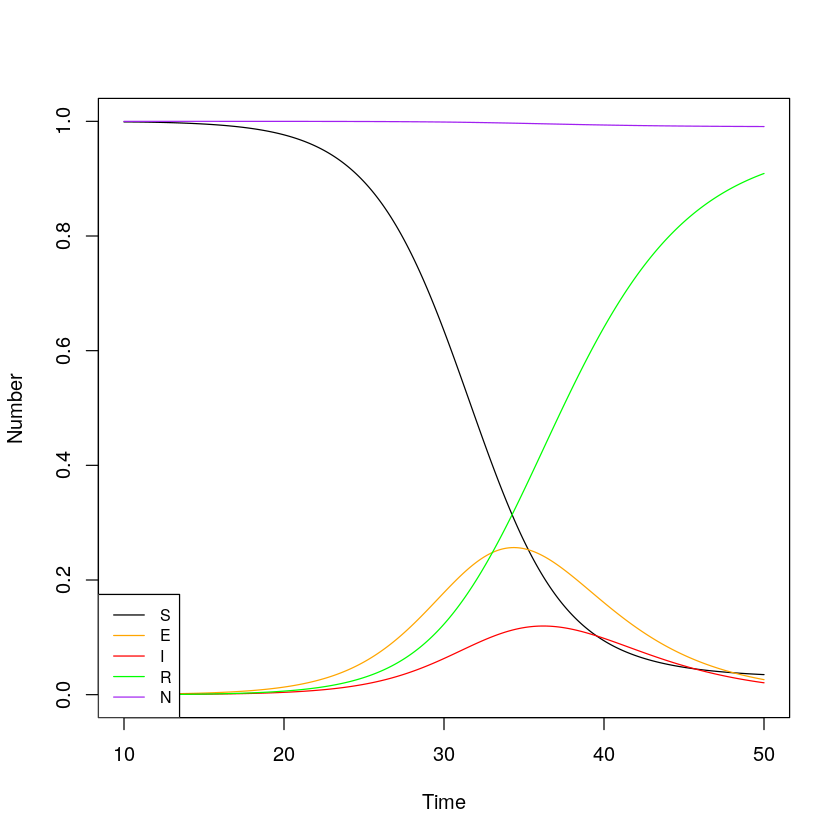

In [9]:
c_climate <- function(temp, humidity) {
  # this function will show how c varies with temp and humidity
  #  return(100/(temp*humidity))
  return(0.1)
}

modelclimatetime <- function(time, values, parms) {
  #function where c changes with the climate and humidity at each timepoint
  S <- values[1]
  E <- values[2]
  I <- values[3]
  R <- values[4]
  
  kappa0 <- parms[["kappa0"]]
  mu <- parms[["mu"]]
  sigma <- parms[["sigma"]]
  alpha <- parms[["alpha"]]
  gamma <- parms[["gamma"]]
  contact <- parms[["contact"]]
  temp <- parms[["temp"]]
  humidity <- parms[["humidity"]]
  nu <- parms[["nu"]]
  N <- parms[["N"]]

  c <- c_climate(temp[time - 10], humidity[time - 10]) #adding time lag
  beta <- -contact * kappa0 * log(1 - c)
 
    
  dS = nu * N - beta * I * S / N - mu * S
  dE = beta * S * I / N - (sigma + mu) * E
  dI = sigma * E - (alpha + mu + gamma) * I
  dR = gamma * I - mu * R

  list(c(dS, dE, dI, dR))
}

time = seq(10, 50, by = 1 / 10)
temp <-
  seq(from = 10,
      to = 30,
      length.out = (length(time) + 10)) #testing the this works with changing temperatures and humidities over time
humidity <- seq(from = 20,
                to = 80,
                length.out = length(time))

#parameters from bjornstad book and guesses- just to test functions work!
parmsclimatetime = list(
  mu = 0,
  sigma = 0.25 ,
  alpha = 0.005,
  kappa0 = 25,
  gamma = 1 / 2,
  contact = 0.7,
  temp = temp,
  humidity = humidity,
  N=1,
  nu=0
)
start = c(S = 0.999,
          E = 0.001,
          I = 0.00,
          R = 0)
plottime(
  time = time,
  parms = parmsclimatetime,
  start = start,
  model = modelclimatetime
)



### Between differences- Spatial Component? 

Simple option- just do for regions with different climates. 

more complex- Potential to make a network to explore effect of movement of people between regions with different climate (Brenner 2017). 

### Climate and Behaviour 

not sure if sufficient data for behaviour and temperature is available

## Proposed model

this is the most simple proposed model. Below this are other options, the functions and variables are not based on biological values but give an idea of the sort of thing I could explore, subsject to understanding covid traits

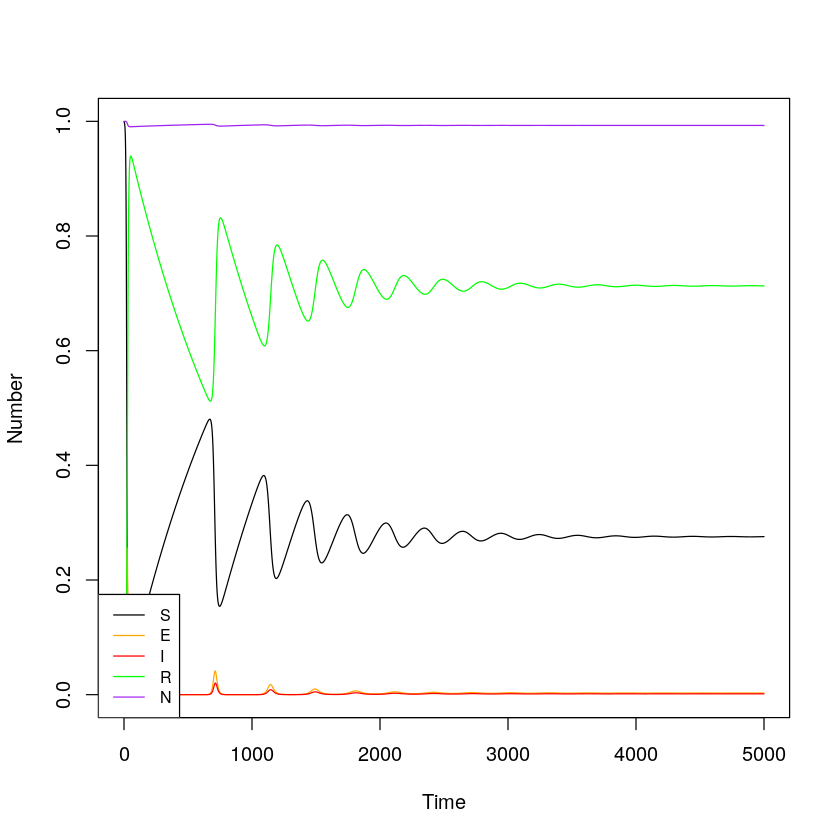

In [10]:
#from above
modelclimate <- function(time, values, parms) {
  #function where c changes with the climate and humidity at each timepoint
  #initial values
  S <- values[1]
  E <- values[2]
  I <- values[3]
  R <- values[4]
  #parameters
  kappa0 <- parms[["kappa0"]]
  mu <- parms[["mu"]]
  sigma <- parms[["sigma"]]
  alpha <- parms[["alpha"]]
  gamma <- parms[["gamma"]]
  contact <- parms[["contact"]]
  #temp and humidity are vectors in this model
  temp <- parms[["temp"]]
  humidity <- parms[["humidity"]]
  nu <- parms[["nu"]]
  N <- parms[["N"]]

  c <- c_climate(temp[time], humidity[time]) #adding time lag
  beta <- -contact * kappa0 * log(1 - c)
 
    
  dS = nu * N - beta * I * S / N - mu * S
  dE = beta * S * I / N - (sigma + mu) * E
  dI = sigma * E - (alpha + mu + gamma) * I
  dR = gamma * I - mu * R

  list(c(dS, dE, dI, dR))
}


c_climate <- function(temp, humidity) {
  # this function will show how c varies with temp and humidity
  return(0.1)
}
time = seq(0, 5000, by = 1 / 10)
#parameters from bjornstad book and guesses- just to test functions work!
parmsclimate = c(
  mu = 0.001,
  sigma = 0.25 ,
  alpha = 0.005,
  kappa0 = 25,
  gamma = 1 / 2,
  contact = 0.7,
  temp = NA,
  humidity = NA,
  nu=0.001,
  N=1
)
start = c(S = 0.999,
          E = 0.001,
          I = 0.00,
          R = 0)
plottime(
  time = time,
  parms = parmsclimate,
  start = start,
  model = modelclimate
)


### R0 for proposed model

In [11]:
parms = list(
  mu = 0,
  sigma = 0.25 ,
  alpha = 0.005,
  kappa0 = (-2 / log(0.9)),
  gamma = 1 / 2,
  contact = 1,
  c = 0.1,
  nu=0,
  N=1
)
beta <- -parms[["contact"]] * parms[["kappa0"]] * log(1 - parms[["c"]])

#replace temp and humidity with a flat rate for c
R0 <-
  (parms[["sigma"]] / (parms[["mu"]] + parms[["sigma"]])) * (beta / (parms[["alpha"]] +
                                                                       parms[["mu"]] + parms[["gamma"]]))

#modified from Bjornstad 2018

R0


[1] 3.960396

### R0 with different parameters

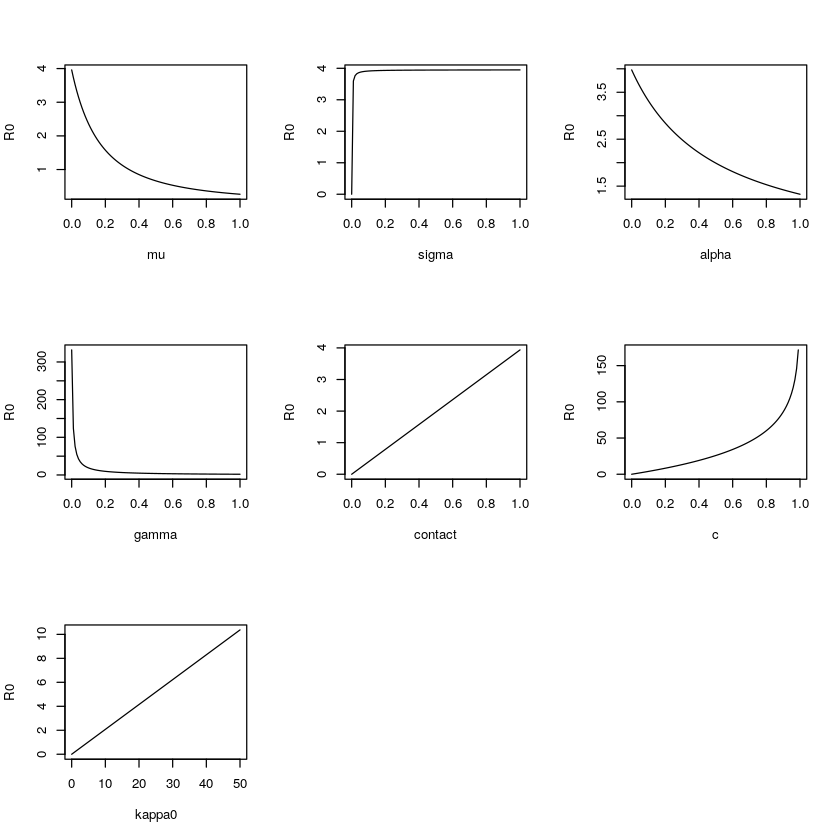

In [20]:

par(mfrow = c(3, 3))
for (i in 1:(length(parms))) {
   parms = list(
    mu = 0.001,
    sigma = 0.25 ,
    alpha = 0.005,
    gamma = 1 / 2,
    contact = 1,
    c = 0.1,
    kappa0 = -2 / log(0.9)
  ) 
    if (i != length(parms)) {
    x <- seq(0, 1, length.out = 100)
  } else{
    x <- seq(0, 50, length.out = 100)
  }
 
  
  parms[[i]] <- x
  R0 <-(parms[["sigma"]] / (parms[["mu"]] + parms[["sigma"]])) * ((-parms[["contact"]] *
        parms[["kappa0"]] * log(1 - parms[["c"]]))) / (parms[["alpha"]] + parms[["mu"]] + parms[["gamma"]])
  plot(x, R0, type = "l", xlab = names(parms[i]))
}



## Adding Complexity in Beta: separating direct and indirect transmission

in the above models-I have combined direct and indirect transmission.  

Could adding another term to beta work? i.e:  
$\beta=-contact_D \times \kappa_{0D} \times \log(1-c_D)-contact_I * \kappa_{0I} \times \log(1-c_I)$for indirect and direct contacts. The indirect value of $c_I$ could be climate dependent.
could also looking into making values of $\kappa_0$ weather depenndent



Alternatively:  
Compartment for viral particles in environment- Brauer 2017 (a new epidemic model with indirect transmission)-This could be excellent but would need a beta for direct transmission and beta for indirect transmission.     
$\frac{dS}{dt}=\nu N -\beta_d VS -\frac{\beta_d IS}{N}-\mu S\\ 
\frac{dE}{dt}=\beta_d VS+\frac{\beta_d IS}{N}-(\sigma+\mu)E \\ 
\frac{dV}{dt} =rI−\delta V\\
$ 
This is modified from Brauer 2017 by looking at units (not sure).  
delta is the rate at which the pathogen loses infectivity  and r is the rate of shedding by an individual.  
I am considering whether it would be better to avoid splitting beta into kappa and c (as it would be an unusual approach) and vary delta with environment instead.  However I would still need to find values for beta (if easier could still split beta into c and kappa).


Need to read more about this approach


In [13]:
plottime

function(start, time, model, parms) {
  out = ode(
    y = start,
    time = time,
    func = model,
    parms = parms
  )
  Nvec<-out[, "S"] + out[, "E"] + out[, "I"] + out[, "R"]
  out<-cbind( out, Nvec)
  plot(x = out[, "time"],    y = out[, "S"],    ylab = "Number",   xlab = "Time",    type = "l",   xlim=c(min(time), max(time)),  ylim=c(0, parms[["N"]])
  )
  lines(x = out[, "time"], y = out[, "E"], col = "orange")
  lines(x = out[, "time"], y = out[, "I"], col = "red")
  lines(x = out[, "time"], y = out[, "R"], col = "green")
  lines(x = out[, "time"], y = out[, "Nvec"], col = "purple")  
  legend( "bottomleft",legend = c("S", "E", "I", "R","N"), col = c("black", "orange", "red", "green","purple"),lty = 1,    cex = 0.8
  )
}
<bytecode: 0x5645ba3f1a28>

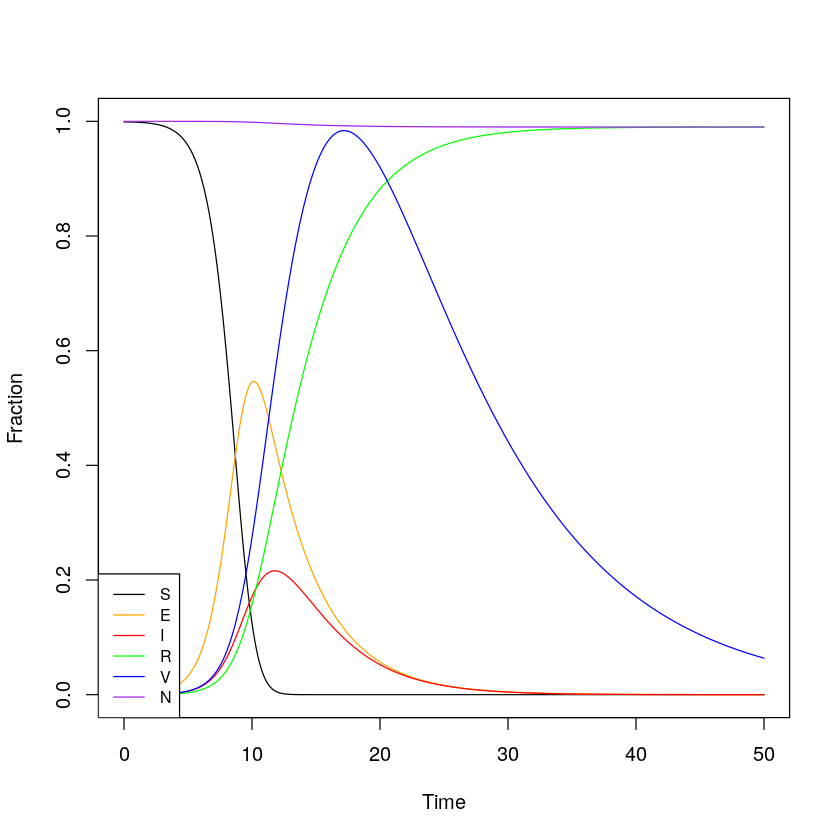

In [16]:
modeltransmissiontype <- function(time, values, parms) {
  #function where c changes with the climate and humidity at each timepoint
  #initial values
  S <- values[1]
  E <- values[2]
  I <- values[3]
  R <- values[4]
  V <- values[5]
  #parameters
  betai <- parms[["betai"]]
  betad <- parms[["betad"]]
  mu <- parms[["mu"]]
  sigma <- parms[["sigma"]]
  alpha <- parms[["alpha"]]
  gamma <- parms[["gamma"]]
  contact <- parms[["contact"]]
  temp <- parms[["temp"]]
  humidity <- parms[["humidity"]]
  r <- parms[["r"]]
  nu <- parms[["nu"]]
  N <- parms[["N"]]
    
  #model
  delta <-
    delta_climate(temp[time], humidity[time]) # in this model ,delta is what varies with climate- the rate at which the pathogen loses infectivity
  #c is determined from a c_climate showing how probability of infection given contact changes with climate
  #beta<--contact*kappa0*log(1-c)
  #seir model with varying beta values
  
  dV = r * I - delta * V  #from brauer 2017
  dS = nu - betai * V * S - betad * I * S / N - mu * S
  dE = betai * V * S + betad * I * S / N - (sigma + mu) * E
  dI = sigma * E - (alpha + mu + gamma) * I
  dR = gamma * I - mu * R
  list(c(dS, dE, dI, dR, dV))
}

plottimev <- function(start, time, model, parms) {
  out = ode(
    y = start,
    time = time,
    func = model,
    parms = parms
  )
   Nvec <- out[, "S"] + out[, "E"] + out[, "I"] + out[, "R"]
   out <- cbind(out, Nvec)
   plot(x = out[, "time"], y = out[, "S"], ylab = "Fraction", xlab = "Time", type = "l", xlim = c(min(time), max(time)), 
        ylim = c(0, parms[["N"]])
  )
  lines(x = out[, "time"], y = out[, "E"], col = "orange")
  lines(x = out[, "time"], y = out[, "I"], col = "red")
  lines(x = out[, "time"], y = out[, "R"], col = "green")
  lines(x = out[, "time"], y = out[, "V"], col = "blue")
   lines(x = out[, "time"], y = out[, "Nvec"], col = "purple")
  legend("bottomleft", legend = c("S", "E", "I", "R", "V","N"), col = c("black", "orange", "red", "green","blue" ,"purple"), 
         lty = 1, cex = 0.8)
}
delta_climate <- function(temp, humidity) {
  # this function will show how v varies with temp and humidity
  return(0.1)
}
time = seq(0, 50, by = 1 / 10)
#parameters from bjornstad book and guesses- just to test functions work! new parameters here are complete guesses
parmstransmissiontype = c(
  mu = 0.0,
  sigma = 0.25 ,
  alpha = 0.005,
  betai = 2,
  betad = 4,
  gamma = 1 / 2,
  contact = 0.7,
  r = 1,
  temp = NA,
  humidity = NA,
  N = 1,
  nu = 0    
)
start = c(
  S = 0.999,
  E = 0.001,
  I = 0.00,
  R = 0,
  V = 0
)

plottimev(
  time = time,
  parms = parmstransmissiontype,
  start = start,
  model = modeltransmissiontype
)

## Modelling Complexity - restored susceptibility--damped oscillations

what would happen if immunity is short term. how might this interact with temperature. 
Brauer 2010- temporary immunity. Model example below. This seems to cause damped oscillations eventually reaching an equilibrium.


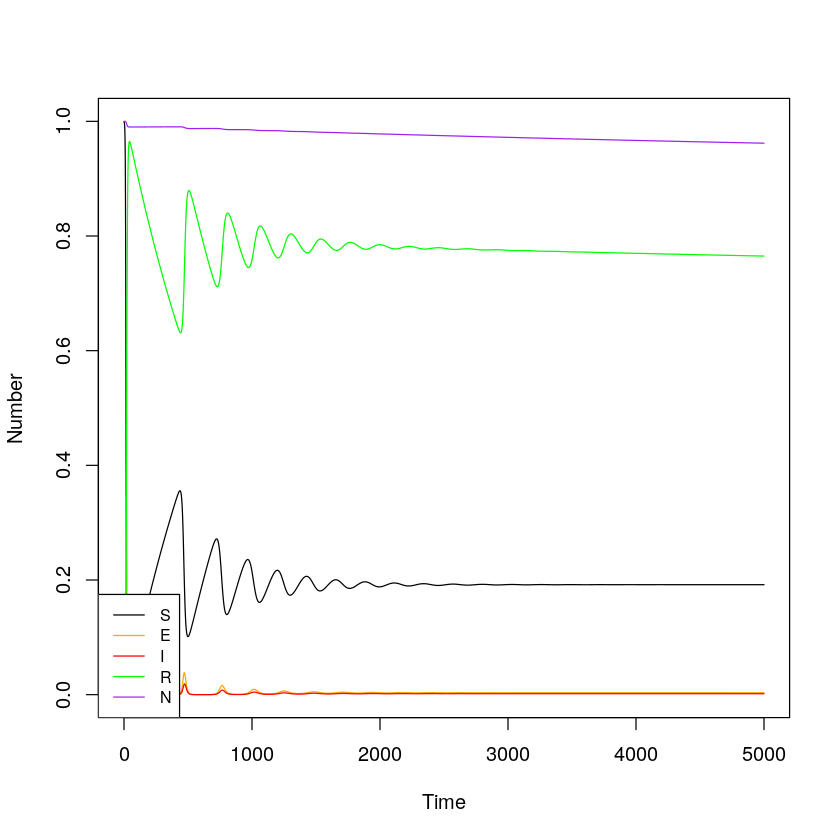

In [19]:


modelsus <- function(time, values, parms) {
  #function where c changes with the climate and humidity at each timepoint
  #initial values
  S <- values[1]
  E <- values[2]
  I <- values[3]
  R <- values[4]
  #parameters
  kappa0 <- parms[["kappa0"]]
  mu <- parms[["mu"]]
  sigma <- parms[["sigma"]]
  alpha <- parms[["alpha"]]
  gamma <- parms[["gamma"]]
  contact <- parms[["contact"]]
  #temp and humidity are vectors in this model
  temp <- parms[["temp"]]
  humidity <- parms[["humidity"]]
  f <- parms[["f"]]
  nu <- parms[["nu"]]
  N <- parms[["N"]]
    
    
  #model
  c <- c_climate(temp[time], humidity[time])
  #c is determined from a c_climate showing how probability of infection given contact changes with climate
  beta <- -contact * kappa0 * log(1 - c)
  #seir model with varying beta values
  dS = nu * N - beta * I * S / N - mu * S + f * R
  dE = beta * S * I / N - (sigma + mu) * E
  dI = sigma * E - (alpha + mu + gamma) * I
  dR = gamma * I - mu * R - f * R

  #f is the rate that immunity is lost
  list(c(dS, dE, dI, dR))
}


c_climate <- function(temp, humidity) {
  # this function will show how c varies with temp and humidity
  return(0.1)
}
time = seq(0, 5000, by = 1 / 10)
#parameters from bjornstad book and guesses- just to test functions work! not sure if this is quite right
parmssus = c(
  mu = 00.0001,
  sigma = 0.25 ,
  alpha = 0.005,
  kappa0 = 25,
  gamma = 1 / 2,
  contact = 1,
  temp = NA,
  humidity = NA,
  f = 1 / 1000,
  N = 1,
  nu = 0.0001
) #if become susceptbile again after 1 year
start = c(S = 0.999,
          E = 0.001,
          I = 0.00,
          R = 0)
plottime(
  time = time,
  parms = parmssus,
  start = start,
  model = modelsus
)

## Addition of seasonality- non-damped oscillations

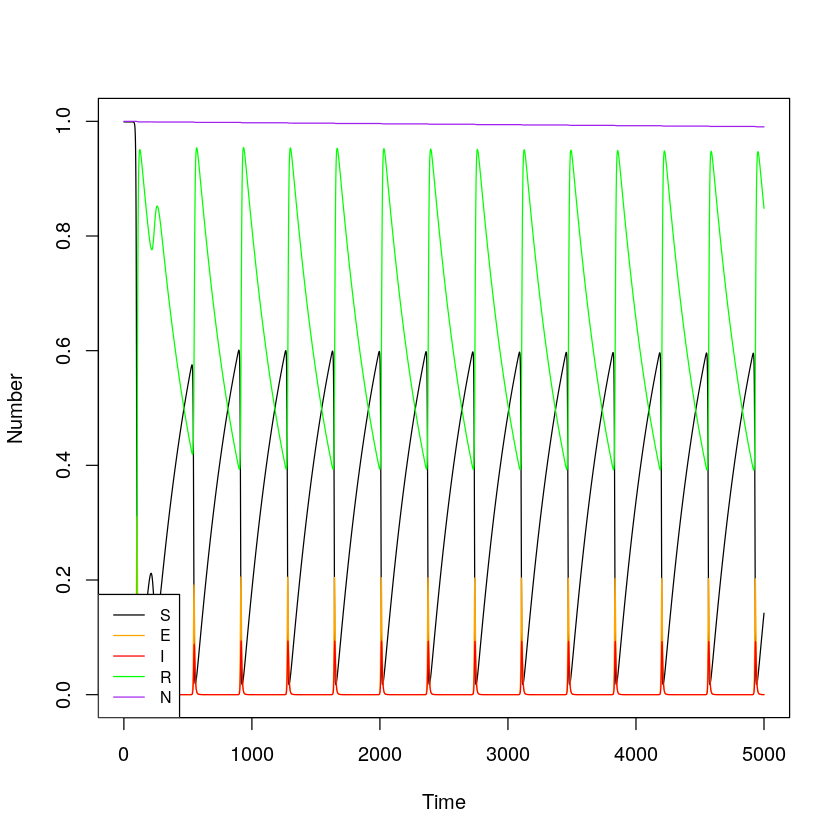

In [23]:
modelsus <- function(time, values, parms) {
  #function where c changes with the climate and humidity at each timepoint
  #initial values
  S <- values[1]
  E <- values[2]
  I <- values[3]
  R <- values[4]
  #parameters
  kappa0 <- parms[["kappa0"]]
  mu <- parms[["mu"]]
  sigma <- parms[["sigma"]]
  alpha <- parms[["alpha"]]
  gamma <- parms[["gamma"]]
  contact <- parms[["contact"]]
  #temp and humidity are vectors in this model
  f <- parms[["f"]]
  nu <- parms[["nu"]]
  N <- parms[["N"]]
    
  #model
  c <- c_climate(temp = temp[time], humidity[time])
  #c is determined from a c_climate showing how probability of infection given contact changes with climate
  beta <- beta(time)
  #seir model with varying beta values
  dS = nu * N - beta * I * S / N - mu * S + f * R
  dE = beta * S * I / N - (sigma + mu) * E
  dI = sigma * E - (alpha + mu + gamma) * I
  dR = gamma * I - mu * R - f * R  
    
  list(c(dS, dE, dI, dR))
}

beta <- function(time) {
  # here, beta is varying with time at a yearly cycle.
  return(2 * sin(2 * pi * (time - 91) / 365) + 2)
}

time = seq(1, 5000, by = 0.01)
#parameters from bjornstad book and guesses- just to test functions work! not sure if this is quite right
parmssus = list(
  mu = 00.000,
  sigma = 0.25 ,
  alpha = 0.0005,
  kappa0 = 25,
  gamma = 1 / 2,
  contact = 1,
  f = 1 / 365,
  N = 1,
  nu = 0.0
)
start = c(S = 0.999,
          E = 0.001,
          I = 0.00,
          R = 0)
plottime(
  time = time,
  parms = parmssus,
  start = start,
  model = modelsus
)

## Covid-19 Specific Models

It seems that the application of a model has the biggest effect on the format of a model. However there are some differences between models usually used for COVID-19 and the proposed model.  
A diseased-induced mortality parameter is not often used. In addition, the models often use numbers instead of proportions.
More reading into models for COVID-19 is needed (particularly ones that have been published in peer reviewed journals already as the majority of work is preprints at this point)
Recent paper (Projecting the transmiission dynamics of SARS-CoV-2 through the postpandemic period) SEIRS model- modelled with varying time to lose immunity. 

## Parameter table

|Parameter|Meaning|Unit|Origin|
|------|------|------|------|
|$\alpha$     |rate of disease induced mortality     |probability of individual dying of disease per unit time|Bjørnstad 2018|
|$\beta$     |transmission rate per infective     |number per individual per unit time     |Keeling and Rohani 2007|
|$\beta_0$     |initial transmission rate (pre-intervention)    |transmission per individual per unit time     |Keeling and Rohani 2007 for $\beta$|
|$\beta_{max}$     |transmission rate in an ideal climate   |transmission per individual per unit time     |Keeling and Rohani 2007 for $\beta$|
|$contact$     |proportion of usual contact rate|-     |related to Neher et al 2020|
|$\gamma$     |recovery rate     |probability of recovering per unit time     |Keeling and Rohani 2007|
|$\mu$    |natural per capita death rate|number of  deaths (not caused by disease) per day|Keeling and Rohani 2007|
|$\nu$    |natural per capita birth rate|number of births per individual per day- $day^-1$ |Keeling and Rohani 2007|
|$\sigma$     |rate of movement from E to I|probability of transition from E to I per unit time|Keeling and Rohani 2007|
|$\kappa$   |average number of contacts per individual per unit time|number per unit time   |Keeling and Rohani 2007|
|$c$     |probability of successful transmission following a contact|-     |Keeling and Rohani 2007|
|$S$     |number of susceptibles    |   -  |Keeling and Rohani 2007|
|$E$     |number of exposed |  -   |Keeling and Rohani 2007|
|$I$     |number of infected     |  -   |Keeling and Rohani 2007|
|$R$     |number of recovered    |  -   |Keeling and Rohani 2007|
|$N$     |number of individuals in population   |  -   |Bjornstad|
|$V$     |pathogen ?density     |  -   |Brauer 2017|
|$\beta_i$    |person-person contact rate||Brauer 2017, tien and earn 2010|
|$\beta_d$     |reservoir-person contact rate||Brauer 2017, Tien and Earn 2010|
|$\kappa_0$    |unmodified average number of contacts|number per unit time||
|$temp$  |temperature |degrees c|-|
|$humidity$   |relative humidity|%|-|
|$\delta$   |rate at which the pathogen loses infectivity (1/delta is lifetime)|? per unit time|Brauer 2017|
|$f$  |rate of loss of immunity|?proportion per unit time|Brauer 2010 (temporary immunity)|
|$r$  |shedding rate|?|Brauer 2017|

 
$\mu$ is the natural death rate per capita (assumed to be equal to the birth rate) per day ($day^-1$).  
$\nu$ is the natural birth rate per capita per day ($day^-1$).  
$\beta$ is the transmission rate per infective per day (i.e the number of individuals that an infective could transmit the disease to in one day-if all contacts are with susceptible)($day^-1$).  The number of susceptible individuals that become exposed is I x the probability that a contact is with a susceptible individual (S/N) x the transmission rate per infective .  
$\gamma$ is the recovery rate (reciprocal of infectious period)($day^-1$) .  
$\sigma$ is the rate of movement from E to I (reciprical of latent period). per capita movement from I to R per day ($day^-1$).  
$\alpha$ is rate of disease induced mortality (per capita disease induced death rate per day).  
 
 
 some not 100% sure of units
 
 some models are scaled, some are not so I'm finding it hard to interpret some of the parameters
